## Swaps and Swaptions

Pre-requisites: Notebook 1.1, 1.2

In this notebook we will create and price **swaps** and **vanilla swaptions**. In that process we will

- use a simple representation for floating payments
- use `HWFDModel` (a Finite Difference Hull-White Model)
- calculate and plot rho by changing the rates in dataset 

API documentation:

- [Utilities to create swaps and swaptions](https://qablet.github.io/qablet-contracts/examples/rate/)
- [Hull White FD model](https://qablet-academy.github.io/intro/models/fd/#hull-white-model)

Let us start with the imports.

In [ ]:
import numpy as np
import pandas as pd
from qablet_contracts.timetable import timetable_from_dicts
from qablet_contracts.rate.swaption import simple_swap_period
from qablet.hullwhite.fd import HWFDModel
from qablet.base.fixed import FixedModel
import matplotlib.pyplot as plt

## Single Swap Period
Before we do that, let us start with a single swap period which pays a fixed rate, and receives a floating rate at the end of the period. e.g.

```
 time quantity
  0.5  - fixed_rate * 0.5
  0.5  + floating rate * 0.5
```

Instead of defining a unit that pays based on a floating rate convention (such as LIBOR or SOFR), we will substitute it with an economically equivalent representation, where we receive notional at the beginning of the period, and pay notional at the end of the period. The utility `simple_swap_period` creates such a pair of events. 

In [ ]:
events = simple_swap_period(ccy="USD", start=0, end=0.5, fixed_rate=.03)
timetable = timetable_from_dicts(events)
print(timetable["events"].to_pandas())

  track  time op  quantity unit
0         0.0  +     1.000  USD
1         0.5  +    -1.015  USD


We can price it using a fixed model, and at 2.977% (which is 3% semi-annual converted to continuous rate) we see that the price is zero.

In [ ]:
def flat_discount_crv(rate, tmax):
    times = np.array([0.0, tmax])
    rates = np.array([rate, rate])
    return ("ZERO_RATES", np.column_stack((times, rates)))

dataset = {
    "BASE": "USD",
    "ASSETS": {"USD": flat_discount_crv(.029777, 5)},
}

fixed_model = FixedModel()
price, _ = fixed_model.price(timetable, dataset)
print(f"price: {price:11.6f}")

price:   -0.000000


## Vanilla Swap
Now we can create a vanilla swap using this building block.

In [ ]:
def vanilla_swap_timetable(ccy, periods, fixed_rate, track="") -> dict:
    """create timetable for a vanilla swap."""
    events = []
    # payment events
    for start, end in zip(periods[0:-1], periods[1:]):
        events.extend(simple_swap_period(ccy, start, end, fixed_rate, track=track))
    return timetable_from_dicts(events)

periods = np.linspace(0.5, 2, 4)  # Start after 6 months, mature at 2 years, pay semi-annually (three periods).
fixed_rate = 0.03
swap_timetable = vanilla_swap_timetable("USD", periods, fixed_rate, "")

print(swap_timetable["events"].to_pandas())

  track  time op  quantity unit
0         0.5  +     1.000  USD
1         1.0  +    -1.015  USD
2         1.0  +     1.000  USD
3         1.5  +    -1.015  USD
4         1.5  +     1.000  USD
5         2.0  +    -1.015  USD


We can price this swap with different shocks to the interest rate curve.

In [ ]:
for shock in range(-2,3):
    dataset["ASSETS"]["USD"] = flat_discount_crv(.029777 + shock * .0001, 5)
    price, _ = fixed_model.price(swap_timetable, dataset)
    print(f"shock {shock:-2d}bps  price: {price:10.6f}")

shock -2bps  price:  -0.000292
shock -1bps  price:  -0.000146
shock  0bps  price:  -0.000000
shock  1bps  price:   0.000145
shock  2bps  price:   0.000291


## A Vanilla Swaption
A Vanilla Swaption is similar to the swap, with a choice in the beginning to enter the swap or not. This can be done using a **>** operation to end the contract with 0 payment, or continue.

In [ ]:
def swaption_timetable(ccy, periods, strike_rate, track="") -> dict:
    # expiration event at beginning
    events = [
        {
                "track": track,
                "time": periods[0],
                "op": ">",
                "quantity": 0,
                "unit": "USD"
            }
    ]
    # payment events
    for start, end in zip(periods[0:-1], periods[1:]):
        events.extend(simple_swap_period(ccy, start, end, strike_rate, track=track))
    return timetable_from_dicts(events)

swo_timetable = swaption_timetable("USD", periods, strike_rate=fixed_rate)
print(swo_timetable["events"].to_pandas())

  track  time op  quantity unit
0         0.5  >     0.000  USD
1         0.5  +     1.000  USD
2         1.0  +    -1.015  USD
3         1.0  +     1.000  USD
4         1.5  +    -1.015  USD
5         1.5  +     1.000  USD
6         2.0  +    -1.015  USD


We will price it with a Hull-White Finite-Difference model, which requires a mean reversion and volatility parameter in the dataset. For details of the model parameters see [Hull White FD model](https://qablet-academy.github.io/intro/models/fd/#hull-white-model).


In [ ]:
hwfd_dataset = {
    "BASE": "USD",
    "ASSETS": {"USD": flat_discount_crv(.029777, 5)},
    "FD": {
        "TIMESTEP": 1 / 250,
        "MAX_X": 0.20,
        "N_X": 75,
    },
    "HW": {
        "MEANREV": 0.1,
        "VOL": 0.03,
    },
}

hw_model = HWFDModel()
price, _ = hw_model.price(swo_timetable, hwfd_dataset)
print(f"price: {price:11.6f}")

price:    0.011118


Let's change the vols.

In [ ]:
for vol in np.linspace(0.0, 0.05, 6):
    hwfd_dataset["HW"]["VOL"] = vol
    price, _ = hw_model.price(swo_timetable, hwfd_dataset)
    print(f"vol: {vol:6.2f} price: {price:11.6f}")

vol:   0.00 price:    0.000000
vol:   0.01 price:    0.003645
vol:   0.02 price:    0.007394
vol:   0.03 price:    0.011118
vol:   0.04 price:    0.014835
vol:   0.05 price:    0.018547


We will now calculate prices and rho for swaps and swaptions, and examine the convexity.

    rate    swap  swaption  swap_rho  swaption_rho  swap_cvx  swaption_cvx
0 0.0000 -0.0450    0.0007    1.5673        0.0907   -3.8462       15.0058
1 0.0100 -0.0295    0.0022    1.5293        0.2242   -3.7669       25.2108
2 0.0200 -0.0144    0.0055    1.4920        0.4457   -3.6891       31.4640
3 0.0300  0.0003    0.0113    1.4555        0.7251   -3.6129       28.6138
4 0.0400  0.0147    0.0199    1.4197        0.9912   -3.5382       18.1491
5 0.0500  0.0287    0.0308    1.3847        1.1790   -3.4650        6.8582
6 0.0600  0.0424    0.0431    1.3504        1.2711   -3.3933       -0.1956


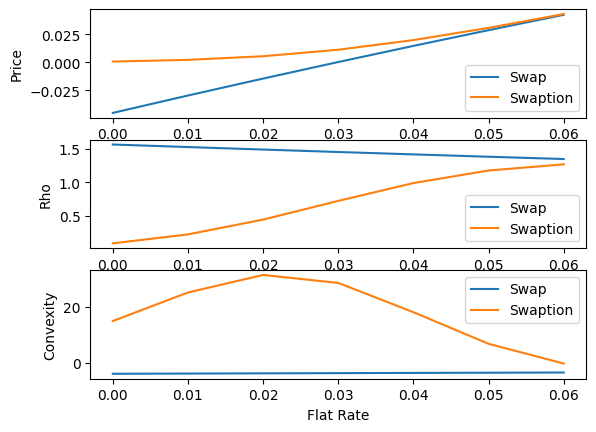

In [ ]:
hwfd_dataset["HW"]["VOL"] = 0.03  # reset vol
shock = 0.001
data = []
for rate in np.linspace(0.0, 0.06, 7):
    # Calculate the swap and swaption prices
    hwfd_dataset["ASSETS"]["USD"] = flat_discount_crv(rate, 5)
    swap_price, _ = hw_model.price(swap_timetable, hwfd_dataset)
    swo_price, _ = hw_model.price(swo_timetable, hwfd_dataset)

    # Calculate rho and cvx
    hwfd_dataset["ASSETS"]["USD"] = flat_discount_crv(rate + shock, 5)
    swap_up, _ = hw_model.price(swap_timetable, hwfd_dataset)
    swo_up, _ = hw_model.price(swo_timetable, hwfd_dataset)

    # Calculate rho and cvx
    hwfd_dataset["ASSETS"]["USD"] = flat_discount_crv(rate - shock, 5)
    swap_dn, _ = hw_model.price(swap_timetable, hwfd_dataset)
    swo_dn, _ = hw_model.price(swo_timetable, hwfd_dataset)

    data.append([
        rate, swap_price, swo_price,
        (swap_up - swap_dn) / (2 * shock),
        (swo_up - swo_dn) / (2 * shock),
        (swap_up + swap_dn - 2 * swap_price) / (shock * shock),
        (swo_up + swo_dn - 2 * swo_price) / (shock * shock)
        ])

pd.options.display.float_format = '{:,.4f}'.format
df = pd.DataFrame(data, columns=["rate", "swap", "swaption",
                                 "swap_rho", "swaption_rho",
                                 "swap_cvx", "swaption_cvx"])
print(df)

# Plot
fig, [ax, ax2, ax3] = plt.subplots(3)
ax.plot(df["rate"], df["swap"], label="Swap")
ax.plot(df["rate"], df["swaption"], label="Swaption")

ax2.plot(df["rate"], df["swap_rho"], label="Swap")
ax2.plot(df["rate"], df["swaption_rho"], label="Swaption")

ax3.plot(df["rate"], df["swap_cvx"], label="Swap")
ax3.plot(df["rate"], df["swaption_cvx"], label="Swaption")

ax.set_ylabel("Price")
ax2.set_ylabel("Rho")
ax3.set_ylabel("Convexity")

ax3.set_xlabel("Flat Rate")

ax.legend()
ax2.legend()
ax3.legend()


## Suggested Exercises

- Create and price a callable bond.